In [ ]:
# Additional REF: https://qdrant.tech/blog/rag-evaluation-guide/

# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally. 

In [1]:
#!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [2]:
#!pip install -qU qdrant-client

We'll also provide our OpenAI key, as well as our Cohere API key.

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [2]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [ ]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [4]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [5]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 3, 6, 10, 55, 20, 954837)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [6]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [7]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [8]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-3.5-turbo` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [9]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI()

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [10]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [11]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the positive reviews provided in the context.'

In [12]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for the movie "John Wick 3". Here is the URL to that review: \'/review/rw4854296/?ref_=tt_urv\'.'

In [13]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, an ex-hitman comes out of retirement to track down the gangsters that killed his dog and took everything from him. With the death of his wife still bitter in his mouth, he seeks vengeance and unleashes a carefully orchestrated maelstrom of destruction against those who try to chase him. The story is filled with violence, action, suspense, and revenge.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [14]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [15]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [16]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'The opinions on John Wick vary. Some people really enjoyed the action and found it to be a smooth and stylish action film, while others thought it was too violent and lacked substance.'

In [17]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"I don't have any reviews with a rating of 10 in the context provided."

In [18]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the action is beautifully choreographed, creating an emotional setup for an action flick. Keanu Reeves stars in this movie.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [19]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [20]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [21]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the reviews provided.'

In [22]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there is a review with a rating of 10. Here is the URL to that review:\n- Review: A Masterpiece & Brilliant Sequel\n- URL: '/review/rw4854296/?ref_=tt_urv'"

In [23]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick 2, after resolving issues with the Russian mafia, John Wick is forced back into action to honor a marker and eliminate a target. This leads to a contract being placed on him, attracting professional killers from all over.'

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [24]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [25]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [26]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, it seems that the majority of people really liked John Wick. The reviews praised the action sequences, Keanu Reeves' performance, and the overall entertainment value of the movie. Therefore, it can be concluded that people generally liked John Wick."

In [27]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"I don't know."

In [28]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In "John Wick: Chapter 1," the story follows John Wick, a retired hitman seeking revenge after his beloved dog is killed and his car is stolen. This sets off a series of events where Wick engages in a one-man war against the Russian Mafia. The film is known for its intense action sequences and the portrayal of Wick as a skilled and ruthless assassin.'

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [29]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [30]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

/tmp/ipykernel_4007154/3574430551.py:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [31]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [32]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [33]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [34]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"People's opinions on John Wick seem to vary. Some really enjoy the series and find it consistent and well-received. However, others have been disappointed with specific installments, such as John Wick 4, criticizing aspects like plot holes and repetitive fight scenes."

In [35]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for the movie "John Wick 3." The URL to that review is \'/review/rw4854296/?ref_=tt_urv\'.'

In [36]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In "John Wick 2", John Wick is a retired assassin who is forced back into action after his car is stolen, leading to a lot of carnage. He is then called on to help take over the Assassin\'s Guild by traveling to Italy, Canada, and Manhattan to eliminate a large number of assassins.'

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [37]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [38]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [39]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews analyzed, the general consensus is that people liked John Wick. The action sequences, Keanu Reeves' performance, and the overall enjoyment factor were highlighted as positives in the reviews. Overall, it seems that the majority of viewers appreciated the film for what it offered."

In [40]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\n- Review by ymyuseda: [Link](/review/rw4854296/?ref_=tt_urv)'

In [41]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, an ex-hitman comes out of retirement to seek revenge on the gangsters who killed his dog and took everything from him. This leads to a series of violent events involving a Russian mob prince, hoodlums, and a bounty on his head. John Wick unleashes a maelstrom of destruction against those who come after him, leading to intense action sequences and fights.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [42]:
#!pip install -qU langchain_experimental

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [43]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [44]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [45]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [46]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [47]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [48]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Overall, people generally liked John Wick based on the reviews provided.'

In [49]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for the movie "John Wick 3." The URL to that review is \'/review/rw4854296/?ref_=tt_urv\'.'

In [50]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, the protagonist, played by Keanu Reeves, seeks revenge on the people who took something he loved from him. It's a simple premise for an action movie, focusing on action, stylish stunts, and kinetic chaos."

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [51]:
### YOUR CODE HERE

In [52]:
import os
import getpass # uv pip install ragas==0.2.10
os.environ["RAGAS_APP_TOKEN"] = getpass.getpass("Please enter your Ragas API key!")

In [53]:
"""
Knowledge Graph Based Synthetic Generation
Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. 
The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.
"""
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

/home/tabesink/Projects/code/AIE5/13_Advanced_Retrieval/.venv/lib/python3.13/site-packages/pysbd/segmenter.py:66: SyntaxWarning: invalid escape sequence '\s'
  for match in re.finditer('{0}\s*'.format(re.escape(sent)), self.original_text):
/home/tabesink/Projects/code/AIE5/13_Advanced_Retrieval/.venv/lib/python3.13/site-packages/pysbd/lang/arabic.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)
/home/tabesink/Projects/code/AIE5/13_Advanced_Retrieval/.venv/lib/python3.13/site-packages/pysbd/lang/persian.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)


In [64]:

from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(documents, testset_size=10)


Applying SummaryExtractor:   0%|          | 0/44 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/100 [00:00<?, ?it/s]

Node c345bcd0-3d1b-4f05-ac60-e8d88bb91978 does not have a summary. Skipping filtering.
Node 6a4e515b-9165-4517-863b-c910f73631f0 does not have a summary. Skipping filtering.
Node 706fc8dc-2565-4ae1-adfb-14a811c46b4c does not have a summary. Skipping filtering.
Node 6cb42089-f3bb-4030-9f8c-2ce819c8acbf does not have a summary. Skipping filtering.
Node dc87201a-b084-49f0-8bec-258ad014a2a0 does not have a summary. Skipping filtering.
Node 9d2854fa-a81c-4ff3-93c8-2454e7a0f3a7 does not have a summary. Skipping filtering.
Node ce93b245-398e-4e11-99ed-4cd02fc29a2b does not have a summary. Skipping filtering.
Node 1dff4d7d-33f2-4f61-b905-054b4cb48685 does not have a summary. Skipping filtering.
Node 532daba1-c89c-450e-a122-ef92335488c0 does not have a summary. Skipping filtering.
Node b9c876ba-7938-49db-ac74-82bcc1515d90 does not have a summary. Skipping filtering.
Node e907eb23-84c4-4c93-be43-a5c29db32ec0 does not have a summary. Skipping filtering.
Node 6f4a81e6-830a-4379-8c09-644802a7584e d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/244 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

In [65]:
dataset.to_csv("ragas_dataset.csv")

In [66]:

dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,How does Keanu Reeves contribute to the succes...,[: 0\nReview: The best way I can describe John...,Keanu Reeves contributes to the success of Joh...,single_hop_specifc_query_synthesizer
1,Wut makes Jon Wick a must-see for action movie...,[: 2\nReview: With the fourth installment scor...,The fourth installment of John Wick is scoring...,single_hop_specifc_query_synthesizer
2,Wht makes Jon Wick stand out among action film...,[: 3\nReview: John wick has a very simple reve...,John Wick stands out due to its virtuoso actio...,single_hop_specifc_query_synthesizer
3,What role do Russian mobsters play in the movi...,[: 4\nReview: Though he no longer has a taste ...,"In the movie John Wick, Russian mobsters are r...",single_hop_specifc_query_synthesizer
4,Wut role duz the Russian mob play in John Wick?,[: 5\nReview: Ultra-violent first entry with l...,"In the original John Wick (2014), an arrogant ...",single_hop_specifc_query_synthesizer
5,What role does Ian McShane play in the film 'J...,"[<1-hop>\n\n: 9\nReview: At first glance, John...","In the film 'John Wick', Ian McShane plays a s...",multi_hop_specific_query_synthesizer
6,How does John Wick: Chapter 4 compare to its p...,[<1-hop>\n\n: 22\nReview: HORRIBLE movie. I lo...,John Wick: Chapter 4 continues the tradition o...,multi_hop_specific_query_synthesizer
7,What are the critical reviews and audience exp...,"[<1-hop>\n\n: 16\nReview: Ok, so I got back fr...",The critical review for John Wick 2 highlights...,multi_hop_specific_query_synthesizer
8,What are the contrasting elements in the revie...,"[<1-hop>\n\n: 21\nReview: ..THE FILM-MAKERS, {...",The reviews of 'John Wick: Chapter 3 - Parabel...,multi_hop_specific_query_synthesizer
9,Why John Wick 2 not surprise like first JOHN W...,[<1-hop>\n\n: 10\nReview: The first John Wick ...,The first John Wick film was surprising becaus...,multi_hop_specific_query_synthesizer


In [69]:
import copy
naive_retrieval_dataset = copy.deepcopy(dataset)
bm25_retrieval_dataset = copy.deepcopy(dataset)
contextual_compression_retrieval_dataset = copy.deepcopy(dataset)
multi_query_retrieval_dataset = copy.deepcopy(dataset)
parent_document_retrieval_dataset = copy.deepcopy(dataset)
ensemble_retrieval_dataset = copy.deepcopy(dataset)
#semantic_retrieval_dataset = copy.deepcopy(dataset)

In [86]:
# running the test queries generated usign SDG above through the application to get context and responses.

#  Create evaluations datasets for each retriever
retriever_chains = [naive_retrieval_chain, bm25_retrieval_chain, contextual_compression_retrieval_chain, multi_query_retrieval_chain, parent_document_retrieval_chain, ensemble_retrieval_chain]
retriever_datasets = [naive_retrieval_dataset, bm25_retrieval_dataset, contextual_compression_retrieval_dataset, multi_query_retrieval_dataset, parent_document_retrieval_dataset, ensemble_retrieval_dataset]
for retriever_chain, retriever_dataset in zip(retriever_chains, retriever_datasets):
  for test_row in retriever_dataset:
    response = retriever_chain.invoke({"question" : test_row.eval_sample.user_input})
    test_row.eval_sample.response = response["response"].content
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]


In [89]:
# convert data tables into a EvaluationDataset to make the process of evaluation smoother.
from ragas import EvaluationDataset

dataset_names = ["naive_retrieval", "bm25_retrieval", "contextual_compression_retrieval", "multi_query_retrieval", "parent_document_retrieval", "ensemble_retrieval"]
evaluation_datasets = {}
for dataset, dataset_name in zip(retriever_datasets, dataset_names):
  evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())
  evaluation_dataset.to_csv(f"evaluation_dataset_{dataset_name}.csv") 
  evaluation_datasets[dataset_name] = evaluation_dataset

In [96]:
# evaluate on our desired metrics
import time
from ragas import evaluate
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas.cost import get_token_usage_for_openai

evaluator_llm = ChatOpenAI(model="gpt-4o")

evaluation_results = {}
for dataset_name, evaluation_dataset in evaluation_datasets.items():
  
  # evaluate on our desired metrics
  start_time = time.time()
  result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    token_usage_parser=get_token_usage_for_openai,
    )
  end_time = time.time()
  
  # evaluate latency
  latency = f"{(end_time - start_time):.2f} seconds"
  
  #  evalute cost (gpt-4o)
  cost = result.total_cost(cost_per_input_token=5 / 1e6, cost_per_output_token=15 / 1e6)
  
  evaluation_results[dataset_name] = {"cost": cost, 
                                      "latency": latency,
                                      "performance": result}

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[11]: TimeoutError()
Exception raised in Job[5]: TimeoutError()
Exception raised in Job[17]: TimeoutError()
Exception raised in Job[23]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[35]: TimeoutError()
Exception raised in Job[53]: TimeoutError()


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[53]: TimeoutError()


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[5]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[17]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[56]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
Exception raised in Job[53]: TimeoutError()


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Exception raised in Job[5]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[17]: TimeoutError()
Exception raised in Job[23]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()


In [98]:
import json

with open('evaluation_results.json', 'w') as f:
    json.dump(evaluation_results, f, indent=2, default=str)
    
evaluation_results

{'naive_retrieval': {'cost': 3.029535,
  'latency': '212.18 seconds',
  'performance': {'context_recall': 0.8833, 'faithfulness': 0.8378, 'factual_correctness': 0.4130, 'answer_relevancy': 0.9506, 'context_entity_recall': 0.6167, 'noise_sensitivity_relevant': 0.0000}},
 'bm25_retrieval': {'cost': 2.020255,
  'latency': '210.89 seconds',
  'performance': {'context_recall': 0.7000, 'faithfulness': 0.6192, 'factual_correctness': 0.3460, 'answer_relevancy': 0.7704, 'context_entity_recall': 0.5750, 'noise_sensitivity_relevant': 0.3177}},
 'contextual_compression_retrieval': {'cost': 1.94889,
  'latency': '219.19 seconds',
  'performance': {'context_recall': 0.7667, 'faithfulness': 0.7741, 'factual_correctness': 0.3790, 'answer_relevancy': 0.8640, 'context_entity_recall': 0.5917, 'noise_sensitivity_relevant': 0.3763}},
 'multi_query_retrieval': {'cost': 3.1325700000000003,
  'latency': '225.24 seconds',
  'performance': {'context_recall': 0.8833, 'faithfulness': 0.7655, 'factual_correctness'

In [149]:
import numpy as np
def format_evaluation_result(evaluation_result):
  return {
    'cost': float(evaluation_result['cost']),
    'latency': float(evaluation_result['latency'].replace(' seconds', '')),
    'context_recall': float(round(np.mean(evaluation_result['performance']['context_recall']), 3)),
    'faithfulness': float(round(np.mean(evaluation_result['performance']['faithfulness']), 3)),
    'factual_correctness': float(round(np.mean(evaluation_result['performance']['factual_correctness']), 3)),
    'answer_relevancy': float(round(np.mean(evaluation_result['performance']['answer_relevancy']), 3)),
    'context_entity_recall': float(round(np.mean(evaluation_result['performance']['context_entity_recall']), 3)),
    'noise_sensitivity_relevant': float(round(np.mean(evaluation_result['performance']['noise_sensitivity_relevant']), 3))
    }

format_evaluation_result(evaluation_results['naive_retrieval'])

{'cost': 3.029535,
 'latency': 212.18,
 'context_recall': 0.883,
 'faithfulness': 0.838,
 'factual_correctness': 0.413,
 'answer_relevancy': 0.951,
 'context_entity_recall': 0.617,
 'noise_sensitivity_relevant': nan}

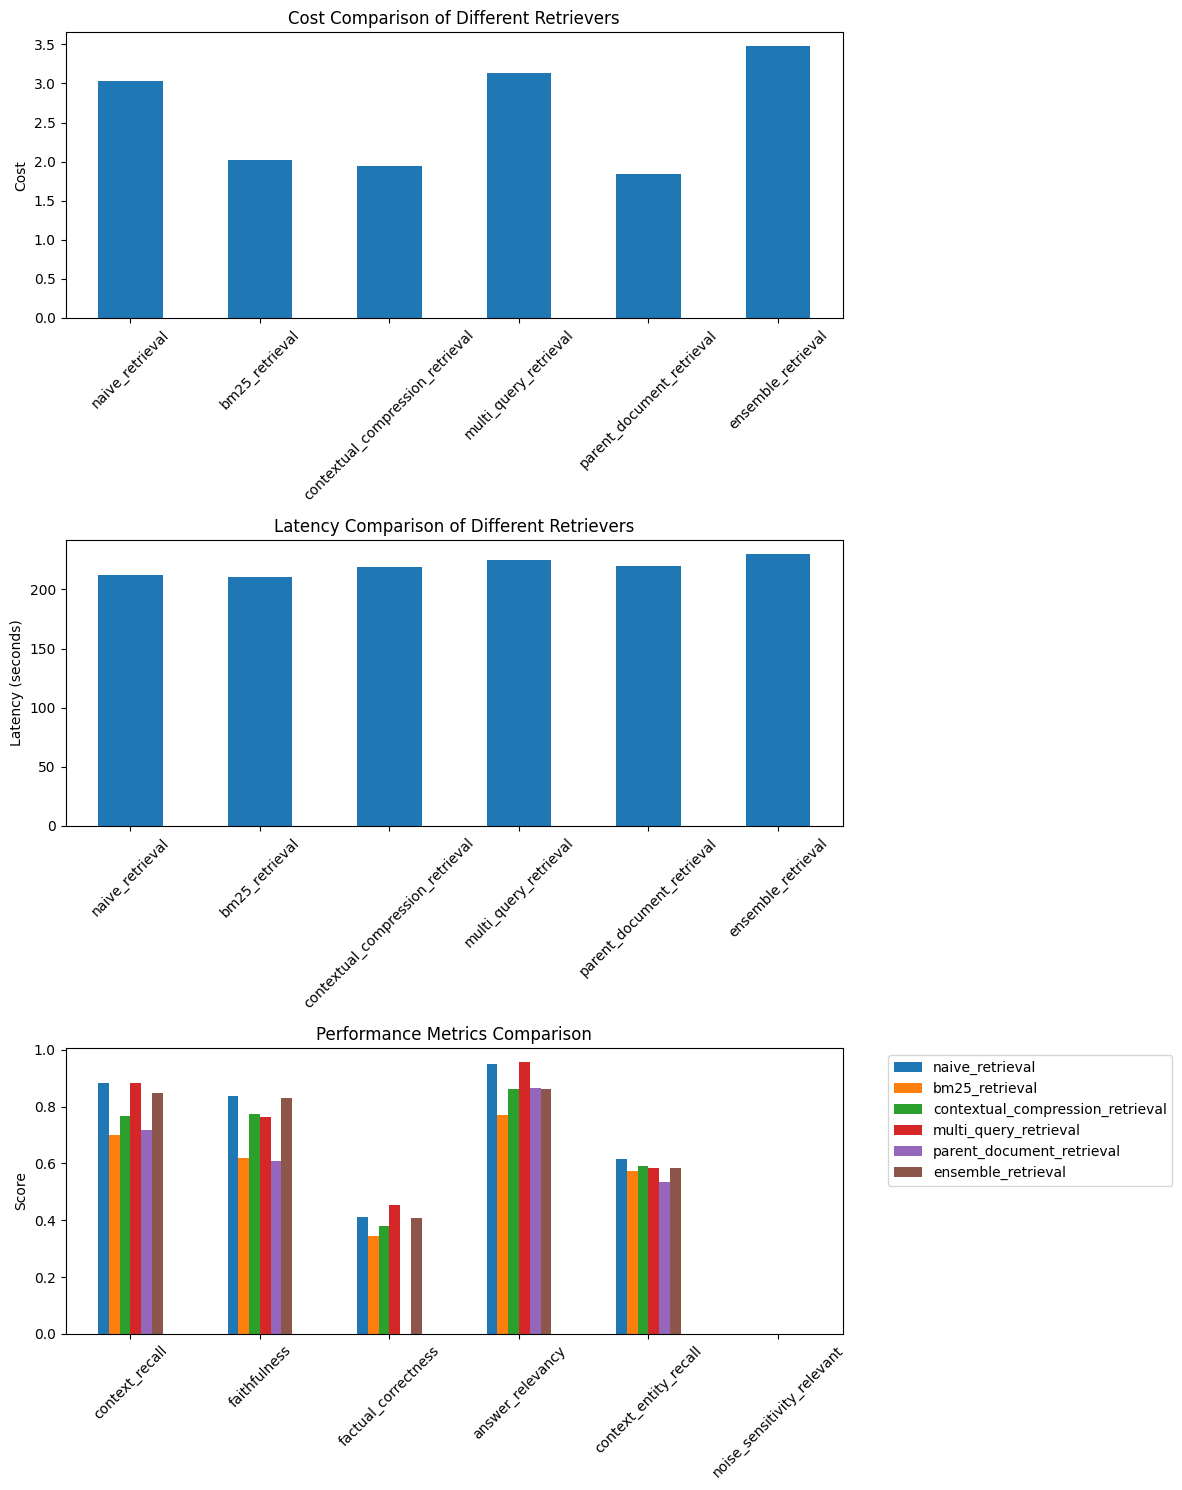

,naive_retrieval,bm25_retrieval,contextual_compression_retrieval,multi_query_retrieval,parent_document_retrieval,ensemble_retrieval
cost,3.029535,2.020255,1.94889,3.13257,1.84608,3.480425
latency,212.180000,210.890000,219.19000,225.24000,219.88000,230.070000
context_recall,0.883000,0.700000,0.76700,0.88300,0.71700,0.850000
faithfulness,0.838000,0.619000,0.77400,0.76500,0.60800,0.831000
factual_correctness,0.413000,0.346000,0.37900,0.45200,NaN,0.407000
answer_relevancy,0.951000,0.770000,0.86400,0.95800,0.86700,0.862000
context_entity_recall,0.617000,0.575000,0.59200,0.58300,0.53300,0.583000
noise_sensitivity_relevant,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
# create a table and plot of the results
import pandas as pd
import matplotlib.pyplot as plt

# Create a table of the results to convert to pandas
results = {}
for retriever_name in evaluation_results:
    evaluation_result = evaluation_results[retriever_name]
    result = format_evaluation_result(evaluation_result)
    results[retriever_name] = result

# Create dataframe
results_df = pd.DataFrame(results)

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

# Plot cost comparison
results_df.loc['cost'].plot(kind='bar', ax=ax1)
ax1.set_title('Cost Comparison of Different Retrievers')
ax1.set_ylabel('Cost')
ax1.tick_params(axis='x', rotation=45)

# Plot latency comparison  
results_df.loc['latency'].plot(kind='bar', ax=ax2)
ax2.set_title('Latency Comparison of Different Retrievers')
ax2.set_ylabel('Latency (seconds)')
ax2.tick_params(axis='x', rotation=45)

# Plot performance metrics
performance_metrics = ['context_recall', 'faithfulness', 'factual_correctness', 
                      'answer_relevancy', 'context_entity_recall', 'noise_sensitivity_relevant']
results_df.loc[performance_metrics].plot(kind='bar', ax=ax3)
ax3.set_title('Performance Metrics Comparison')
ax3.set_ylabel('Score')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Display dataframe
results_df


In [155]:
# Analyze the results and write a summary paragraph
analysis = """Based on the evaluation results, the multi_query_retrieval approach appears to be the best choice for this particular movie review data, despite not being the cheapest option. Here's why:

Performance: It achieves the highest scores in several key metrics:
- Tied for highest context_recall (0.883)
- Highest factual_correctness (0.452) 
- Highest answer_relevancy (0.958)

While its cost ($3.13) is higher than BM25 ($2.02) or parent document retrieval ($1.85), and its latency (225.24s) is slightly above average, the superior performance metrics justify the tradeoff. The high context recall and answer relevancy are particularly important for a movie review system where accurate information retrieval is crucial.

The naive retrieval approach shows similar performance in some areas but costs slightly less, while ensemble retrieval offers comparable results but at the highest cost ($3.48) and latency (230.07s). The cheaper options like BM25 and parent document retrieval show notably lower performance across most metrics, making them less suitable despite their cost advantages."""

print(analysis)


Based on the evaluation results, the multi_query_retrieval approach appears to be the best choice for this particular movie review data, despite not being the cheapest option. Here's why:

Performance: It achieves the highest scores in several key metrics:
- Tied for highest context_recall (0.883)
- Highest factual_correctness (0.452) 
- Highest answer_relevancy (0.958)

While its cost ($3.13) is higher than BM25 ($2.02) or parent document retrieval ($1.85), and its latency (225.24s) is slightly above average, the superior performance metrics justify the tradeoff. The high context recall and answer relevancy are particularly important for a movie review system where accurate information retrieval is crucial.

The naive retrieval approach shows similar performance in some areas but costs slightly less, while ensemble retrieval offers comparable results but at the highest cost ($3.48) and latency (230.07s). The cheaper options like BM25 and parent document retrieval show notably lower pe